In [1]:
import quantumhall_matrixelements 
import copy
import matplotlib.pyplot as plt
import numpy as np

Note: Julia and Python use different indexing (column moajor vs row major). Saving an HDF5 file in julia and then using that in python usually reverses the order of the dimensions. The matrix elements from julia in the HDF5 file takes that into account

In [2]:
import h5py

#Matrix elements from Julia code. Maximum n = 10 and G is randomly sampled up to Gx,Gy in [-20,20]

path = "Exchange_pwme_julia_code.h5"
#load Exchange_pwme_julia_code.h5py
with h5py.File(path, "r") as f:
    print("top-level datasets:", list(f.keys()))
    Xs_julia_with_phase = f["Xs"][:]          # replace "Xs" with whatever dataset name you see
    Fs_julia = f["pwme"][:]
    Gs_julia = f["G_vecs"][:]         # replace "Gs" with whatever dataset name you see

nmax = 10

Gs_py = Gs_julia
Gs_mag = np.linalg.norm(Gs_py, axis=1)
Gs_angles = np.atan2(Gs_py[:,1], Gs_py[:,0])

Fs = quantumhall_matrixelements.get_form_factors(Gs_mag,Gs_angles, nmax, sign_magneticfield=-1)

#quadrature points increased to 7000 for better accuracy
X_gl_py = quantumhall_matrixelements.get_exchange_kernels(Gs_mag, Gs_angles, nmax, method="gausslegendre", sign_magneticfield = -1, nquad=7000)
# hankel is extremely slow, but highly accurate
X_hk_py = quantumhall_matrixelements.get_exchange_kernels(Gs_mag, Gs_angles, nmax, method="hankel",sign_magneticfield = -1)


top-level datasets: ['G_vecs', 'Xs', 'pwme']


\begin{align}
F_{n'n}^\sigma(\mathbf q)
&\equiv e^{-|q|^2/4}\,
\sqrt{\frac{m!}{M!}}\,i^{|n'-n|}\left(\frac{q_\sigma}{\sqrt{2}}\right)^{n'-n} L_m^{M-m}\left(\frac{|q|^2}{2}\right).\\
m &=\min(n,n'),\qquad  M=\max(n,n'),\qquad q_\sigma = q_x + \sigma i q_y
\end{align}

Relating oppositve magnetic field cyclotron matrix element
$$
F^{-\sigma}_{n'n} (\bm q)= {(-1)}^{|n'-n|} (F^{\sigma}_{n'n})^*(\bm q)
$$

Exchange matrix elements:
$$
U_F^\sigma(a_1 b_1, a_2 b_2; \mathbf G)
= \int \frac{d^2 q}{(2\pi)^2}\,
[V_c]_{q} F_{a_2 b_2}^\sigma(\mathbf q)\,
F_{a_1 b_1}^\sigma(-\mathbf q)\,
e^{i\sigma\,\mathbf q\wedge\mathbf G}
$$
Then, relating the Exchange integral of the oppositve magnetic field:
$$
U_F^{-\sigma}(a_1 b_1, a_2 b_2; \mathbf G) = (-1)^{|a_1 - b_1| + |a_2-b_2|}(U_F^{\sigma})^*(a_1 b_1, a_2 b_2; \mathbf G)
$$
This is implemented below

In [3]:
#transforming Julia matrix elements to match Packages B field convention

julia_X_full = Xs_julia_with_phase.astype(np.complex128, copy=True)
julia_X_full_transformed = julia_X_full.astype(np.complex128, copy=True)
theta_val = np.atan2(1.0, 1.0)  # This is the value optained from the Julia code
for i in range(nmax):
    for j in range(nmax):
        for k in range(nmax):
            for l in range(nmax):
                julia_X_full_transformed[:,i,j,k,l] = np.conj(julia_X_full[:,i,j,k,l]) * (-1)**(i - j + l - k)

Fs_julia_transformed = Fs_julia.astype(np.complex128, copy=True)
for g_idx in range(Gs_py.shape[0]):
    theta_val = Gs_angles[g_idx]
    for i in range(nmax):
        for j in range(nmax):
            Fs_julia_transformed[g_idx,i,j] = (np.conj(Fs_julia[g_idx,i,j])) * (-1)**(i-j)


In [4]:
#form factors
diff_form_factors = (np.abs(Fs-Fs_julia_transformed))
max_idx_ff = np.unravel_index(np.argmax(diff_form_factors), diff_form_factors.shape)
max_val_ff = diff_form_factors[max_idx_ff]
print("Form Factors:")
print("max abs. diff. of form factors:", max_val_ff, "at index", max_idx_ff)
print("julia value at max idx:", Fs_julia_transformed[max_idx_ff])
print("gl value at max idx:", Fs[max_idx_ff])
print("")
#exchange matrix elements
#Gauss Legendre
diff_exchange_gl = np.abs(X_gl_py - julia_X_full_transformed)
max_idx_exchange_gl = np.unravel_index(np.argmax(diff_exchange_gl), diff_exchange_gl.shape)
max_val_exchange_gl = diff_exchange_gl[max_idx_exchange_gl]
print("Gauss Legendre:")
print("max abs. diff. of exchange:", max_val_exchange_gl, "at index", max_idx_exchange_gl)
print("julia value at max idx:", julia_X_full_transformed[max_idx_exchange_gl])
print("gl value at max idx:", X_gl_py[max_idx_exchange_gl])
print("")
#Hankel
diff_exchange_hk = np.abs(X_hk_py - julia_X_full_transformed)
max_idx_exchange_hk = np.unravel_index(np.argmax(diff_exchange_hk), diff_exchange_hk.shape)
max_val_exchange_hk = diff_exchange_hk[max_idx_exchange_hk]
print("Hankel:")
print("max abs. diff. of exchange:", max_val_exchange_hk, "at index", max_idx_exchange_hk)
print("julia value at max idx:", julia_X_full_transformed[max_idx_exchange_hk])
print("hk value at max idx:", X_hk_py[max_idx_exchange_hk])


Form Factors:
max abs. diff. of form factors: 9.27313781318162e-14 at index (np.int64(30), np.int64(9), np.int64(9))
julia value at max idx: (-0.16574749743209707-0j)
gl value at max idx: (-0.1657474974321898+0j)

Gauss Legendre:
max abs. diff. of exchange: 6.218731372398256e-05 at index (np.int64(83), np.int64(9), np.int64(9), np.int64(9), np.int64(9))
julia value at max idx: (0.23489314417425536+0j)
gl value at max idx: (0.23483095686053138+0j)

Hankel:
max abs. diff. of exchange: 4.366663697297213e-10 at index (np.int64(83), np.int64(9), np.int64(9), np.int64(9), np.int64(9))
julia value at max idx: (0.23489314417425536+0j)
hk value at max idx: (0.234893143737589+0j)


# Checking whether code matches convention for negative magnetic field

In [5]:
import h5py
#Matrix elements from Julia code. Maximum n = 10 and G is randomly sampled up to Gx,Gy in [-20,20]

path = "Exchange_pwme_julia_code.h5"
#load Exchange_pwme_julia_code.h5py
with h5py.File(path, "r") as f:
    print("top-level datasets:", list(f.keys()))
    Xs_julia_with_phase = f["Xs"][:]          # replace "Xs" with whatever dataset name you see
    Fs_julia = f["pwme"][:]
    Gs_julia = f["G_vecs"][:]         # replace "Gs" with whatever dataset name you see

nmax = 10

#quadrature points increased to 7000 for better accuracy
Gs_py = Gs_julia
Gs_mag = np.linalg.norm(Gs_py, axis=1)
Gs_angles = np.atan2(Gs_py[:,1], Gs_py[:,0])

sigma_set = +1 #setting sigma to +1 for negative B field
#PWME
Fs = quantumhall_matrixelements.get_form_factors(Gs_mag,Gs_angles, nmax, sign_magneticfield=sigma_set)
#Exchange matrix elements
X_gl_py = quantumhall_matrixelements.get_exchange_kernels(Gs_mag, Gs_angles, nmax, method="gausslegendre",sign_magneticfield = sigma_set, nquad=7000)
# hankel is extremely slow, but highly accurate
X_hk_py = quantumhall_matrixelements.get_exchange_kernels(Gs_mag, Gs_angles, nmax, method="hankel",sign_magneticfield = sigma_set)



top-level datasets: ['G_vecs', 'Xs', 'pwme']


In [6]:
print(f"maximum diff. for PWME between Package and Julia with sigma = {sigma_set} is {np.max(np.abs(Fs - Fs_julia))}")
print(f"maximum diff.for Exchange matrix element between Package and Julia with sigma = {sigma_set} is {np.max(np.abs(X_gl_py - Xs_julia_with_phase))}")
print(f"maximum diff.for Exchange matrix element between Package and Julia with sigma = {sigma_set} is {np.max(np.abs(X_hk_py - Xs_julia_with_phase))}")

maximum diff. for PWME between Package and Julia with sigma = 1 is 9.27313781318162e-14
maximum diff.for Exchange matrix element between Package and Julia with sigma = 1 is 6.218731372398256e-05
maximum diff.for Exchange matrix element between Package and Julia with sigma = 1 is 4.366663697297213e-10


# Checking Exchange matrix elements with analytic ones 

$$
U_F^{\ell\ell'}(\tilde n n' \mid n \tilde n') = 
\int \frac{d^2 (q\ell_B)}{(2\pi)^2}\,
\left(\frac{V^{\ell\ell'}_q}{\ell_B^2}\right)
F_{\tilde n n'}(\bm  q\ell_B)\,
F_{n\tilde n'}(-\bm q \ell_B).
$$
$$
V_q ^{\ell \ell'} = \frac{2\pi e^2}{\sqrt{\epsilon_\perp \epsilon_{zz}} q} e^{- q \ell_B (|\ell-\ell'|/\ell_B)\sqrt{\epsilon_\perp/\epsilon_{zz}}}
$$
$$
V_q ^{\ell \ell'} = \frac{2\pi e^2}{q} e^{- q \ell_B (|\ell-\ell'|/\ell_B)}
$$
$$

    F_{n'n}(\ell_B\bm{q}) = \sqrt{\frac{m!}{M!}} \left(\frac{l_B}{\sqrt{2}} |q|\right)^{|n'-n|} i^{|n'-n|} \left(\frac{q_+}{|q|}\right)^{n'-n} e^{-|q|^2 \ell_B^2/4} L^{|n'-n|}_{m}(|q|^2 \ell_B^2/2)\\
    m = \operatorname{min}(n',n),\quad M = \operatorname{max}(n',n)
$$

0th LL exchange matrix element (intralayer):
$$
\frac{e^2}{\epsilon \ell_B}\int_0 ^\infty dx e^{-x^2 /2} = \frac{e^2}{\epsilon \ell_B} \sqrt{\frac{\pi}{2}}
$$

In [7]:
nmax = 1
q = np.linspace(0.0, 0.0, 1)
theta = np.zeros_like(q)
X_gl = quantumhall_matrixelements.get_exchange_kernels(q, theta, nmax, method="gausslegendre")
X_hk = quantumhall_matrixelements.get_exchange_kernels(q, theta, nmax, method="hankel")
print("Exchange element 0th LL analytic value:",np.sqrt(np.pi/2))
print("Exchange Element difference 0th LL (Hankel)",np.sqrt(np.pi/2) - X_hk[0, 0, 0, 0, 0])
print("Exchange Element difference 0th LL (Gauss-Laguerre)",np.sqrt(np.pi/2) - X_gl[0, 0, 0, 0, 0])

Exchange element 0th LL analytic value: 1.2533141373155001
Exchange Element difference 0th LL (Hankel) (2.220446049250313e-16+0j)
Exchange Element difference 0th LL (Gauss-Laguerre) (5.4416504591481285e-05+0j)


1st LL exchange matrix element (intralayer):
$$
\frac{e^2}{\epsilon \ell_B}\int_0 ^\infty dx e^{-x^2 /2} \left(1-\frac{x^2}{2}\right)^2= \frac{e^2}{\epsilon \ell_B} \frac
{3}{4}\sqrt{\frac{\pi}{2}}
$$

In [8]:
nmax = 2
q = np.linspace(0.0, 0.0, 1)
theta = np.zeros_like(q)
X_gl = quantumhall_matrixelements.get_exchange_kernels(q, theta, nmax, method="gausslegendre")
X_hk = quantumhall_matrixelements.get_exchange_kernels(q, theta, nmax, method="hankel")
print("Exchange element 0th LL analytic value:",(3/4)*np.sqrt(np.pi/2))
print("Exchange Element difference 0th LL (Hankel)",(3/4)*np.sqrt(np.pi/2) - X_hk[0, 1, 1, 1, 1])
print("Exchange Element difference 0th LL (Gauss-Laguerre)",(3/4)*np.sqrt(np.pi/2) - X_gl[0, 1, 1, 1, 1])

Exchange element 0th LL analytic value: 0.9399856029866251
Exchange Element difference 0th LL (Hankel) (-1.6653345369377348e-15+0j)
Exchange Element difference 0th LL (Gauss-Laguerre) (5.4416505075094435e-05+0j)


Interlayer interaction 

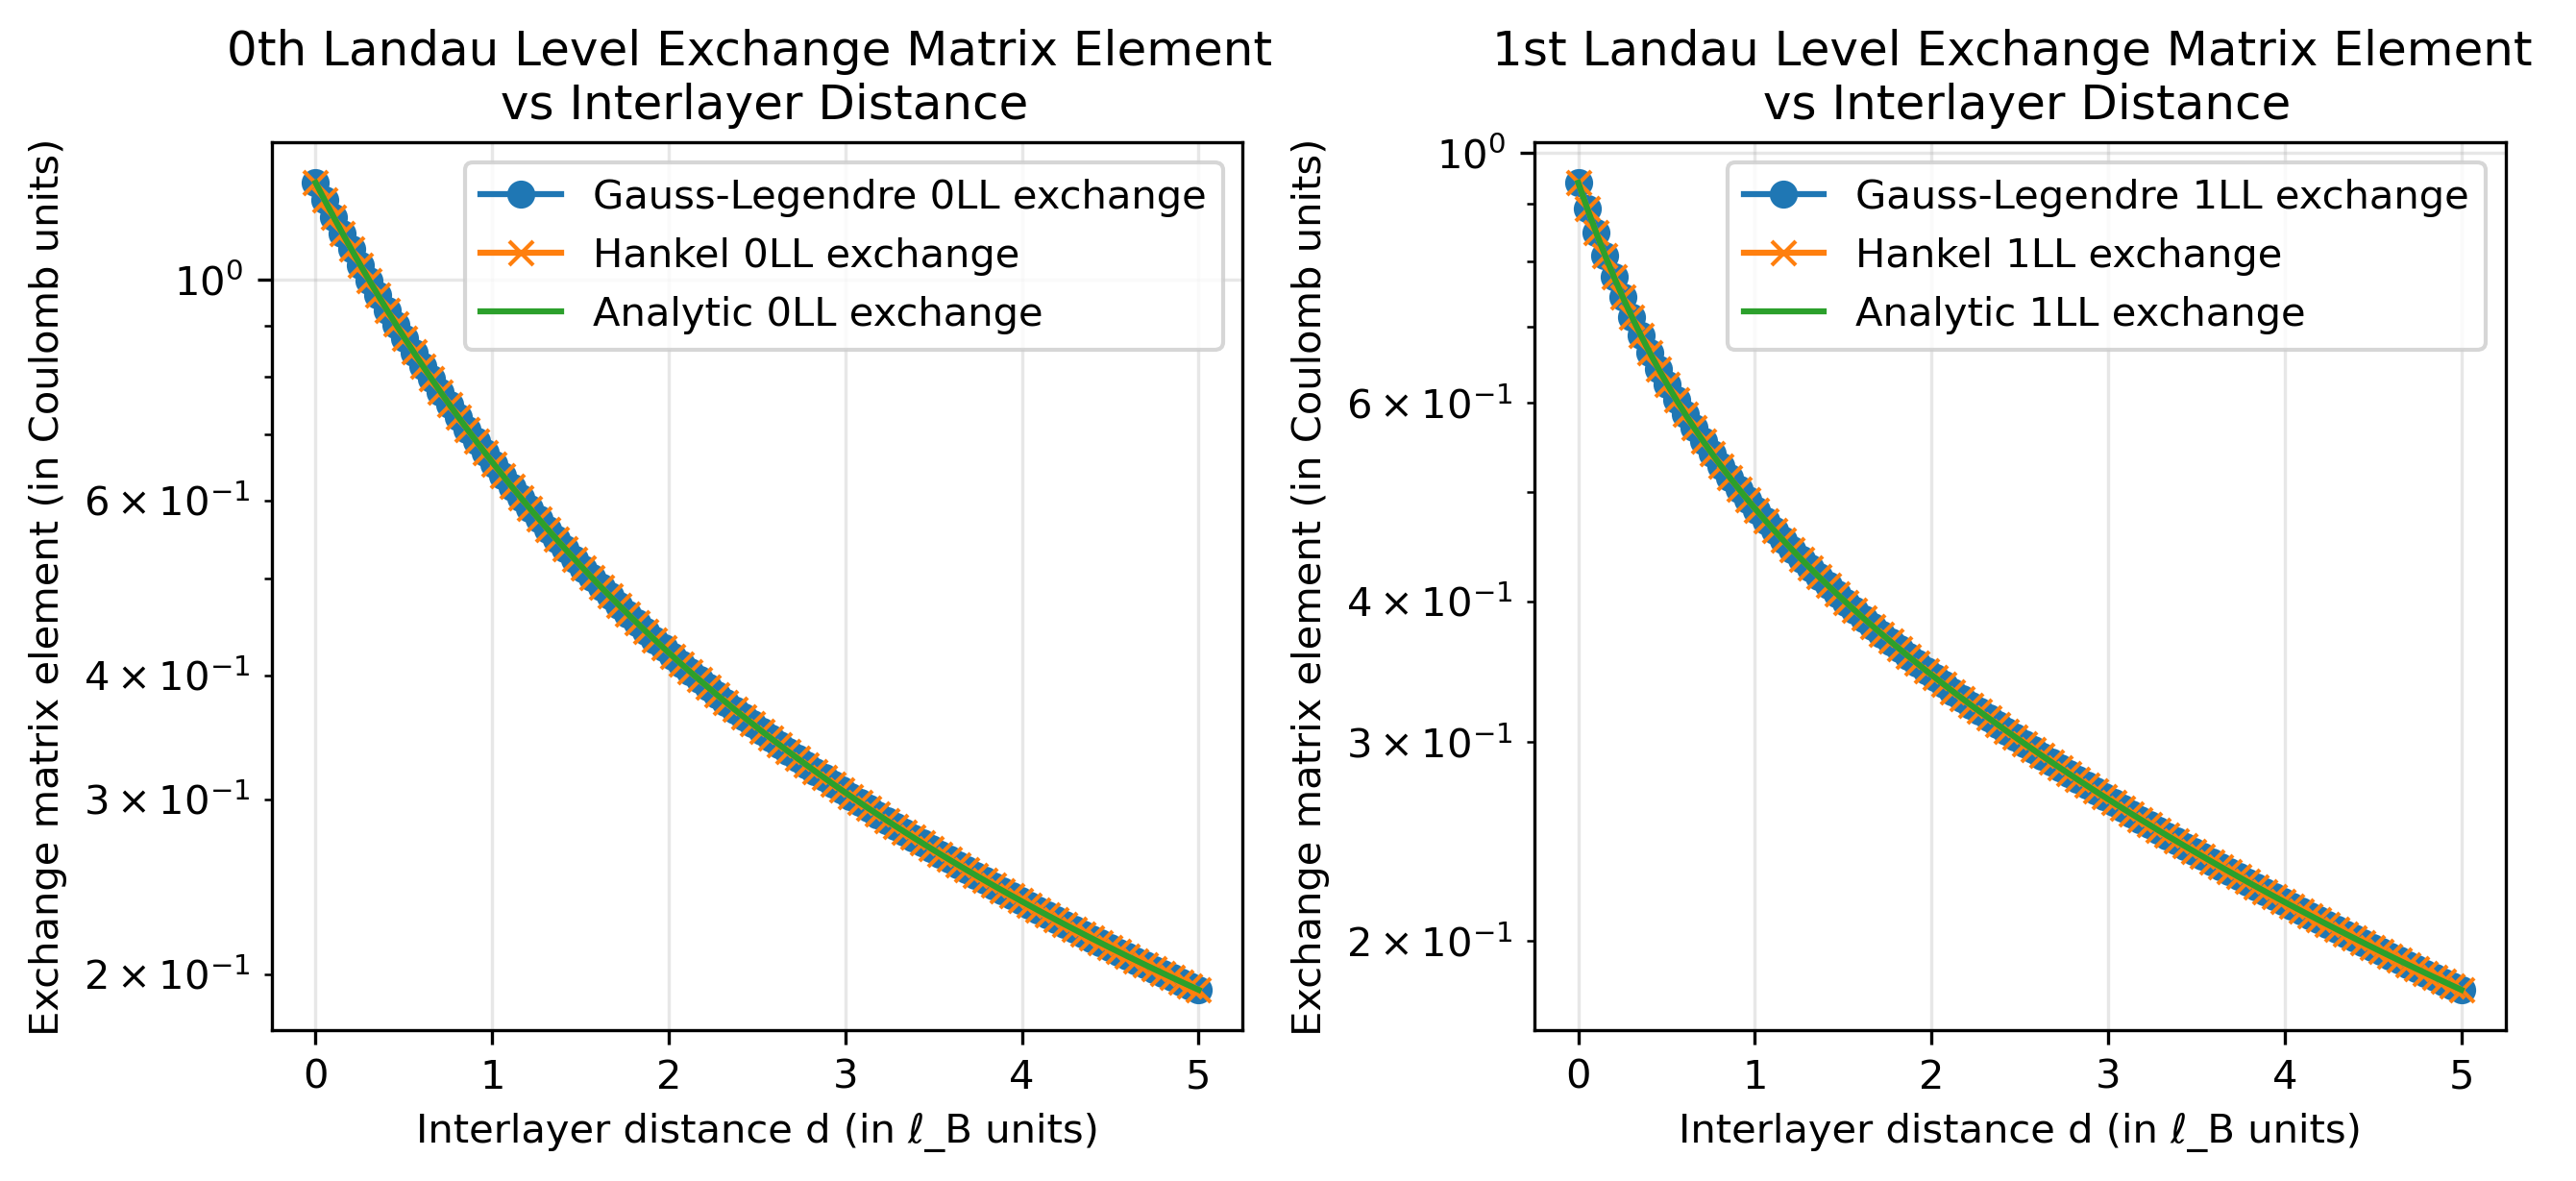

In [10]:
from scipy.special import erfc
def exchange_0LL(d):
    d_clip = 700  # to prevent overflow in exp
    d = np.clip(d, -d_clip, d_clip)
    return np.exp(d**2 / 2) * erfc(d / np.sqrt(2)) * np.sqrt(np.pi / 2)
def exchange_1LL(d):
    d_clip = 700  # to prevent overflow in exp
    d = np.clip(d, -d_clip, d_clip)
    term1 = -2*(d + d**3)/8
    term2 = (3 + 2*d**2 + d**4) * np.exp(d**2 / 2) * erfc(d / np.sqrt(2))* np.sqrt(2*np.pi) /8
    return term1 + term2
def V_coulomb(q, d,kappa=1.0):
    # q is in 1/ℓ_B units; this returns V(q) in Coulomb units
    d_clip = 700  # to prevent overflow in exp
    d = np.clip(d, -d_clip, d_clip)
    return kappa * 2.0 * np.exp(- q * d) *  np.pi / q

d = np.linspace(0.0,5.0,100)
analytic_0LL_exchange = exchange_0LL(d)
analytic_1LL_exchange = exchange_1LL(d)
nmax = 2
q = np.linspace(0.0, 0.0, 1)
theta = np.zeros_like(q)
X_gl = np.array([
    quantumhall_matrixelements.get_exchange_kernels(
        q, theta, nmax,
        method="gausslegendre",
        potential=lambda qq, d_val=d[i]: V_coulomb(qq, d_val)
    )
    for i in range(len(d))
])
X_hk = np.array([
    quantumhall_matrixelements.get_exchange_kernels(
        q, theta, nmax,
        method="hankel",
        potential=lambda qq, d_val=d[i]: V_coulomb(qq, d_val)
    )
    for i in range(len(d))
])

fig ,ax = plt.subplots(dpi = 300, ncols=2, figsize=(10,4))
fig.subplots_adjust(wspace=0.3)
ax[0].plot(d, np.real(X_gl[:,0,0,0,0,0]), '-o', label="Gauss-Legendre 0LL exchange")
ax[0].plot(d, np.real(X_hk[:,0,0,0,0,0]), '-x', label="Hankel 0LL exchange")
ax[0].plot(d, analytic_0LL_exchange, label="Analytic 0LL exchange")

ax[0].set_xlabel("Interlayer distance d (in ℓ_B units)")
ax[0].set_ylabel("Exchange matrix element (in Coulomb units)")
ax[0].set_title("0th Landau Level Exchange Matrix Element \n vs Interlayer Distance")
ax[0].set_yscale("log")
ax[1].plot(d, np.real(X_gl[:,0,1,1,1,1]), '-o', label="Gauss-Legendre 1LL exchange")
ax[1].plot(d, np.real(X_hk[:,0,1,1,1,1]), '-x', label="Hankel 1LL exchange")
ax[1].plot(d, analytic_1LL_exchange, label="Analytic 1LL exchange")

ax[1].set_xlabel("Interlayer distance d (in ℓ_B units)")
ax[1].set_ylabel("Exchange matrix element (in Coulomb units)")
ax[1].set_title("1st Landau Level Exchange Matrix Element \n vs Interlayer Distance")
ax[1].set_yscale("log")

ax[1].legend()
ax[0].legend()
ax[0].grid(True, alpha=0.3)
ax[1].grid(True, alpha=0.3)
plt.show()

In [11]:
print("max difference hankel-analytic",np.max(np.abs(X_hk[:,0,0,0,0,0] - analytic_0LL_exchange)))
print("max difference glegendre-analytic 0LL",np.max(np.abs(X_gl[:,0,0,0,0,0] - analytic_0LL_exchange)))

max difference hankel-analytic 1.251554415659939e-12
max difference glegendre-analytic 0LL 5.441650496629258e-05


In [12]:
print("max difference hankel-analytic",np.max(np.abs(X_hk[:,0,1,1,1,1] - analytic_1LL_exchange)))
print("max difference glegendre-analytic 1LL",np.max(np.abs(X_gl[:,0,1,1,1,1] - analytic_1LL_exchange)))

max difference hankel-analytic 1.3340051285837262e-11
max difference glegendre-analytic 1LL 5.4416505301913e-05
